In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from matplotlib import pyplot as plt

In [2]:
app_files = ["console_2019-01-03_13-12-33.log", "console_2019-01-03_13-37-47.log", 
             "console_2019-01-04_11-36-43.log", "console_2019-01-04_12-36-20.log", "console_2019-01-04_12-48-20.log"]
rl_files = ["run_length_2019-01-03_13-04-37.log", "run_length_2019-01-03_14-14-09.log", 
            "run_length_2019-01-04_11-51-28.log", "run_length_2019-01-04_12-41-08.log",
           "run_length_2019-01-04_12-53-43.log"]

In [3]:
objects = {"[0, 0, 0, 0, 0, 0]":"none",
           "[1, 0, 0, 0, 0, 0]":"cards", 
           "[0, 1, 0, 0, 0, 0]":"dice", 
           "[0, 0, 1, 0, 0, 0]":"key",
           "[0, 0, 0, 1, 0, 0]":"map", 
           "[0, 0, 0, 0, 1, 0]":"phone", 
           "[0, 0, 0, 0, 0, 1]":"ball"}

In [4]:
def read_app_file(file_name):
    with open("data/" + file_name, "r") as f:
        lines  = f.readlines()
        data = lines[2:-2]
        data_list = []
        for line in data:
            object_time = line.split("$1")[1].split("-")[1].strip().split(",")
            if object_time[0] == 'cancel':
                data_list.pop()
            else:
                object_time[1] = float(object_time[1].strip())
                data_list.append(object_time)
    return data_list

In [5]:
def read_rl_file(file_name):
    with open("data/" + file_name, "r") as f:
        lines  = f.readlines()
        hit_scan_list = []
        for line in lines:
            parts = line.split(";")
            time = float(parts[1].split("-")[1])
            glass1 = parts[2].split("-")[1]
            glass2 = parts[3].split("-")[1]
            hit_scan_list.append((time, objects.get(glass1), objects.get(glass2)))
    return hit_scan_list

In [6]:
def create_ds(app_file, rl_file):
    app_data = read_app_file(app_file)
    hsl_data = read_rl_file(rl_file)        

    ot_rl = []
    last_e_ind=0
    for i, ot in enumerate(app_data):
        s_time = ot[1]

        if i != 0:
            s_ind = last_e_ind
        else:
            for j, hsl in enumerate(hsl_data):
                if hsl[0] > s_time:
                    s_ind = j-1
                    break

        if i != (len(app_data) -1):
            e_time = app_data[i+1][1]
            e_ind = 0
            for j, hsl in enumerate(hsl_data[s_ind:]):
                if hsl[0] > e_time:
                    e_ind = s_ind + j
                    break
            rl = hsl_data[s_ind:e_ind]
            last_e_ind = e_ind
        else:
            rl = hsl_data[s_ind:]
        
        new_ot = ot.copy()
        new_ot.append(rl)
        ot_rl.append(new_ot)
    return ot_rl   

In [7]:
def process_ds(ot_rl_list):
    new_ot_rl = []
    for ot_rl in ot_rl_list:
        obj = ot_rl[0]
        rl_data = ot_rl[2]
        timeseries = []
        detections = []
        for rl in rl_data:
            timeseries.append(rl[0])
            detection = 0
            if obj == rl[1] and obj == rl[2]:
                detection = 1
            detections.append(detection)
        rld = {"ts":timeseries, "hits":detections}
        new_data = (obj, ot_rl[1], rld)
        new_ot_rl.append(new_data)
    return new_ot_rl

In [8]:
tot_ot_rl = []
for i in range(len(app_files)):
    ot_rl = create_ds(app_files[i], rl_files[i])
    tot_ot_rl.extend(ot_rl)

In [9]:
new_ot_rl = process_ds(tot_ot_rl)

In [10]:
class RunLengthFilter:
    
    def __init__(self, ot_rl_list, true_look_size, true_look_delta):
        self.data = ot_rl_list
        self.true_size = true_look_size
        self.true_delta = true_look_delta
        self.true_looks = self.determine_true_looks()
        
    def rl_filter(self, window_size, num_ones):
        
        df = {'object':[], 'app_time':[], 'look_time':[], 'true_look_start':self.true_looks, 'is_true_look':[]}
        diff = window_size - num_ones
        
        for idx, ot_rl in enumerate(self.data):
            df['object'].append(ot_rl[0])
            df['app_time'].append(ot_rl[1])
            
            rl_data = ot_rl[2]
            ts = rl_data['ts']
            hits = rl_data['hits']
            
            s_time = look_time = 0
            true_look = self.true_looks[idx]
            
            for i in range(-diff, len(ts)):
                if i<0:
                    s_idx = 0
                else:
                    s_idx = i
                e_idx = i + window_size
                if hits[s_idx] == 1 and sum(hits[s_idx:e_idx]) >= num_ones:
                    look_time = ts[e_idx-1]
                    s_time = ts[s_idx]
                    break
            df['look_time'].append(look_time)
            if s_time >= true_look:
                df["is_true_look"].append(1)
            else:
                df["is_true_look"].append(0)
                
        df = pd.DataFrame(df)
        df['latency'] = df['look_time'] - df['app_time']
        return df
    
    def determine_true_looks(self):
        start_look = []
        for ot_rl in self.data:
            rl_data = ot_rl[2]
            ts = rl_data['ts']
            hits = rl_data['hits']
            start_time = 0
            delta = self.true_delta
            start_idx = 0
            for i in range(len(ts)):
                start_idx = i
                e_idx = i + self.true_size
                if sum(hits[i:e_idx]) == self.true_size:
                    while (delta > 0):
                        if i-delta >= 0 and hits[i-delta] == 1:
                            start_idx = i-delta
                            break
                        delta -= 1
                    break
            start_look.append(ts[start_idx])
        return start_look

In [11]:
rl = RunLengthFilter(new_ot_rl, 4, 3)

In [12]:
rl3_df = rl.rl_filter(3, 3)
rl4_df = rl.rl_filter(4, 4)
rl1_df = rl.rl_filter(1, 1)
rl2_df = rl.rl_filter(2, 2)
rl32_df = rl.rl_filter(3, 2)
rl43_df = rl.rl_filter(4, 3) 

In [13]:
def summary(df_rl):
    rl_dict = {}
    for obj in df_rl["object"].unique():
        df = df_rl[df_rl["object"] == obj]
        m = round(np.mean(df["latency"]), 3)
        s = round(np.std(df["latency"]), 3)
        tpr = get_tpr(df)
        rl_dict[obj] = [m, s, tpr]
    return rl_dict

def get_tpr(df):
    return round((sum(df['is_true_look']) * 100) / len(df), 3)

In [14]:
rl3_dict = summary(rl3_df)
rl4_dict = summary(rl4_df)
rl1_dict = summary(rl1_df)
rl2_dict = summary(rl2_df)
rl32_dict = summary(rl32_df)
rl43_dict = summary(rl43_df)

In [15]:
table = PrettyTable(["Object", "RL1 Mean(Std)", "RL2 Mean(Std)", "RL(3,2) Mean(Std)", "RL3 Mean(Std)", "RL(4,3) Mean(Std)", 
                     "RL4 Mean(Std)"])
for obj in rl3_df["object"].unique():
    table.add_row([obj, "{} ({})".format(rl1_dict[obj][0], rl1_dict[obj][1]),
                   "{} ({})".format(rl2_dict[obj][0], rl2_dict[obj][1]),
                   "{} ({})".format(rl32_dict[obj][0], rl32_dict[obj][1]),
                   "{} ({})".format(rl3_dict[obj][0], rl3_dict[obj][1]),
                   "{} ({})".format(rl43_dict[obj][0], rl43_dict[obj][1]),
                   "{} ({})".format(rl4_dict[obj][0], rl4_dict[obj][1])])
print(table)

+--------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Object |   RL1 Mean(Std)   |   RL2 Mean(Std)    | RL(3,2) Mean(Std)  |   RL3 Mean(Std)    | RL(4,3) Mean(Std)  |   RL4 Mean(Std)    |
+--------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  ball  | 873.096 (169.562) |  924.543 (181.77)  | 965.117 (187.907)  | 978.691 (190.201)  | 1017.649 (193.36)  | 1025.66 (197.471)  |
| cards  |  1008.67 (171.51) | 1071.213 (184.451) | 1111.085 (184.489) | 1159.979 (253.218) | 1196.872 (256.126) | 1214.479 (268.151) |
|  dice  | 833.862 (233.149) |  911.17 (263.449)  | 946.787 (264.409)  | 974.096 (290.791)  | 1007.809 (290.193) | 1011.117 (290.25)  |
|  key   | 826.351 (226.823) | 887.043 (242.837)  | 926.202 (243.635)  | 965.574 (300.988)  | 1005.064 (302.061) | 1008.447 (300.756) |
|  map   |  795.181 (137.79) |  849.255 (155.05)

In [16]:
table = PrettyTable(["Object", "RL1 TPR","RL2 TPR", "RL(3,2) TPR", "RL3 TPR", "RL(4,3) TPR", "RL4 TPR"])
for obj in rl3_df["object"].unique():
    table.add_row([obj, rl1_dict[obj][2], rl2_dict[obj][2], rl32_dict[obj][2], rl3_dict[obj][2], rl43_dict[obj][2], rl4_dict[obj][2]])
print(table)

+--------+---------+---------+-------------+---------+-------------+---------+
| Object | RL1 TPR | RL2 TPR | RL(3,2) TPR | RL3 TPR | RL(4,3) TPR | RL4 TPR |
+--------+---------+---------+-------------+---------+-------------+---------+
|  ball  |  88.298 |  90.426 |    90.426   |  97.872 |    97.872   |  100.0  |
| cards  |  82.979 |  85.106 |    85.106   |  95.745 |    95.745   |  100.0  |
|  dice  |  85.106 |  93.617 |    93.617   |  100.0  |    98.936   |  100.0  |
|  key   |  85.106 |  90.426 |    90.426   |  98.936 |    98.936   |  100.0  |
|  map   |  91.489 |  93.617 |    93.617   |  97.872 |    97.872   |  100.0  |
+--------+---------+---------+-------------+---------+-------------+---------+


ball


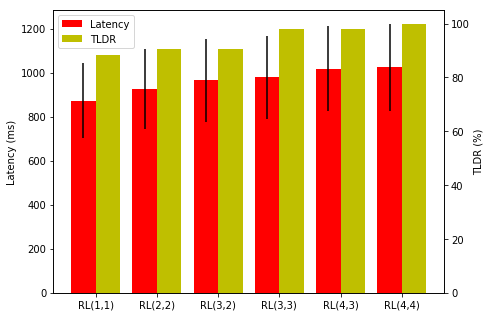

cards


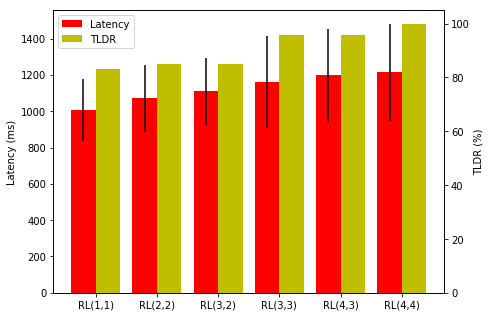

dice


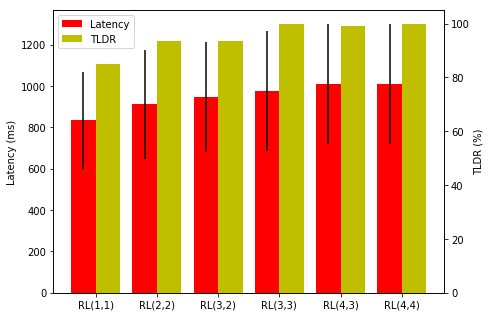

key


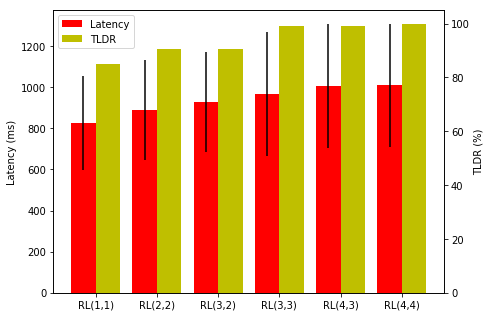

map


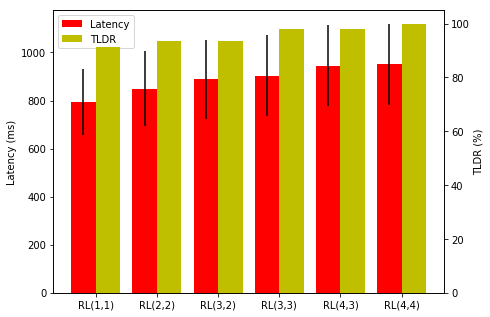

In [18]:
for obj in rl3_df["object"].unique():
    obj_dict = {'labels':['RL(1,1)','RL(2,2)','RL(3,2)','RL(3,3)','RL(4,3)', 'RL(4,4)'], 
            'mean':[rl1_dict[obj][0], rl2_dict[obj][0], rl32_dict[obj][0], rl3_dict[obj][0], rl43_dict[obj][0], rl4_dict[obj][0]], 
            'std':[rl1_dict[obj][1], rl2_dict[obj][1], rl32_dict[obj][1], rl3_dict[obj][1], rl43_dict[obj][1], rl4_dict[obj][1]], 
            'tpr':[rl1_dict[obj][2], rl2_dict[obj][2], rl32_dict[obj][2], rl3_dict[obj][2], rl43_dict[obj][2], rl4_dict[obj][2]]}
    print(obj)
    fig = plt.figure(figsize=(7,5.2)) # Create matplotlib figure

    ind  = np.arange(6)
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    width = 0.4
    rects1 = ax.bar(ind, obj_dict['mean'], width, color='r', yerr=obj_dict['std'])
    rects2 = ax2.bar(ind + width, obj_dict['tpr'], width, color='y')

    ax.set_ylabel('Latency (ms)')
    ax2.set_ylabel('TLDR (%)')
    
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(obj_dict['labels'])
    ax.legend((rects1[0], rects2[0]), ('Latency', 'TLDR'), loc=2)
    plt.savefig(obj + ".png")
    plt.show()

In [22]:
table2 = PrettyTable(['Metric', 'RL(1,1)','RL(2,2)','RL(3,2)','RL(3,3)','RL(4,3)', 'RL(4,4)'])
table2.add_row(['Mean Latency', round(np.mean(rl1_df['latency']), 2), round(np.mean(rl2_df['latency']), 2),
            round(np.mean(rl32_df['latency']), 2), round(np.mean(rl3_df['latency']), 2), 
            round(np.mean(rl43_df['latency']), 2), round(np.mean(rl4_df['latency']), 2)])
table2.add_row(['Std Latency', round(np.std(rl1_df['latency']), 2), round(np.std(rl2_df['latency']), 2),
            round(np.std(rl32_df['latency']), 2), round(np.std(rl3_df['latency']), 2), 
            round(np.std(rl43_df['latency']), 2), round(np.std(rl4_df['latency']), 2)])
table2.add_row("TLDR", get_tpr()                                               